## Student Retention Model

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
data = pd.read_csv('student-por.csv',sep=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [6]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [7]:
data['G3'].describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

In [8]:
data.shape

(649, 33)

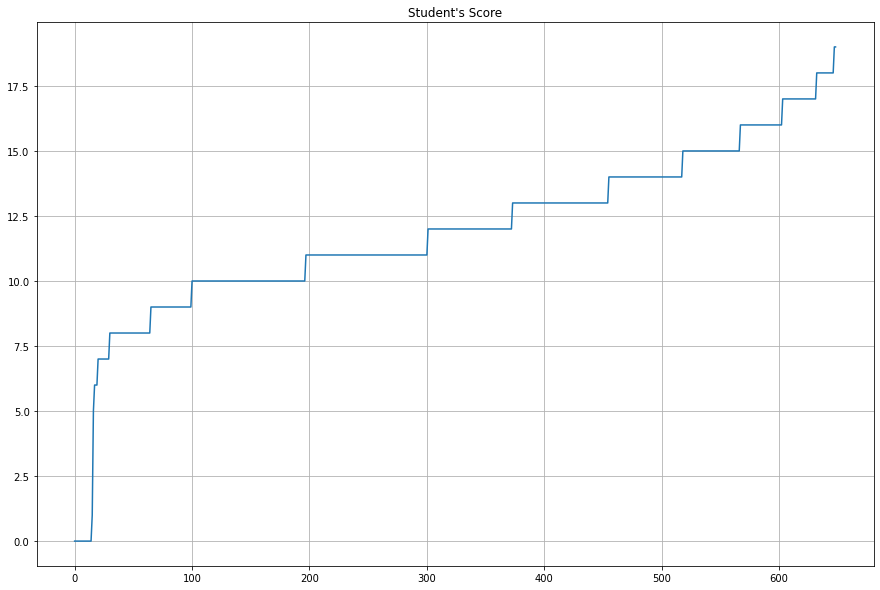

In [18]:
plt.plot(sorted(data['G3']))
plt.title("Student's Score")
plt.grid()

### Exploration & Feature Engineering

In [25]:
# get all non numerical columns in the data

non_numerical_feat = [cols for cols in list(data) if cols not in list(data._get_numeric_data().columns)]
for cols in non_numerical_feat:
    print(f"{cols} : {set(data[cols])}")

school : {'MS', 'GP'}
sex : {'M', 'F'}
address : {'R', 'U'}
famsize : {'GT3', 'LE3'}
Pstatus : {'T', 'A'}
Mjob : {'services', 'other', 'at_home', 'teacher', 'health'}
Fjob : {'services', 'other', 'at_home', 'teacher', 'health'}
reason : {'reputation', 'other', 'course', 'home'}
guardian : {'father', 'other', 'mother'}
schoolsup : {'no', 'yes'}
famsup : {'no', 'yes'}
paid : {'no', 'yes'}
activities : {'no', 'yes'}
nursery : {'no', 'yes'}
higher : {'no', 'yes'}
internet : {'no', 'yes'}
romantic : {'no', 'yes'}


In [30]:
for cols in non_numerical_feat:
    dummies = pd.get_dummies(data[cols]).rename(columns = lambda x : cols + '_' + str(x))
    data = pd.concat([data,dummies],axis=1)

In [32]:
data = data[[cols for cols in list(data) if cols not in non_numerical_feat]]

In [35]:
data.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


### XGBoost

In [36]:
outcome = 'G3'
features = [cols for cols in list(data) if cols not in outcome]

In [100]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,data[outcome],
                                                    test_size = 0.3,random_state = 2021)

In [101]:
import xgboost as xgb

xgb_params = {
    'eta' : 0.01,                     # learning rate, default = 0.3
    'max_depth' : 3,                  # maximum depth of the tree, default = 6
    'subsample' : 0.7,                # randomly sample the training data prior to growing trees to prevent overfitting, default = 1
    'colsample_bytree' : 0.7,         # fraction of the columns to be subsampled, default = 1
    'objective' : 'reg:squarederror', # loss function to be minimized, default reg:squarederror
    'seed' : 0                        # random number seed to make reproducible results
}

In [102]:
dtrain = xgb.DMatrix(x_train[features], y_train, feature_names = features)
dtest = xgb.DMatrix(x_test[features], y_test, feature_names = features)
evals = [(dtrain,'train'),(dtest,'eval')]

In [103]:
xgb_model = xgb.train(
    
    params = xgb_params,
    dtrain = dtrain,
    num_boost_round = 2000,
    verbose_eval = 25,
    early_stopping_rounds = 500,
    evals = evals,
    maximize  = False #rmse is used, so we have to minimize it
)

[0]	train-rmse:11.70022	eval-rmse:11.82682
[25]	train-rmse:9.18494	eval-rmse:9.29489
[50]	train-rmse:7.22100	eval-rmse:7.32103
[75]	train-rmse:5.69796	eval-rmse:5.78896
[100]	train-rmse:4.52042	eval-rmse:4.60998
[125]	train-rmse:3.61409	eval-rmse:3.70268
[150]	train-rmse:2.91144	eval-rmse:3.00357
[175]	train-rmse:2.38142	eval-rmse:2.48073
[200]	train-rmse:1.97984	eval-rmse:2.09303
[225]	train-rmse:1.67830	eval-rmse:1.80428
[250]	train-rmse:1.45594	eval-rmse:1.60174
[275]	train-rmse:1.29731	eval-rmse:1.45864
[300]	train-rmse:1.18202	eval-rmse:1.35834
[325]	train-rmse:1.10055	eval-rmse:1.29291
[350]	train-rmse:1.04102	eval-rmse:1.25200
[375]	train-rmse:0.99799	eval-rmse:1.22461
[400]	train-rmse:0.96454	eval-rmse:1.21149
[425]	train-rmse:0.93632	eval-rmse:1.20110
[450]	train-rmse:0.91381	eval-rmse:1.19478
[475]	train-rmse:0.89376	eval-rmse:1.19345
[500]	train-rmse:0.87788	eval-rmse:1.19183
[525]	train-rmse:0.86317	eval-rmse:1.19029
[550]	train-rmse:0.84963	eval-rmse:1.19151
[575]	train-rm

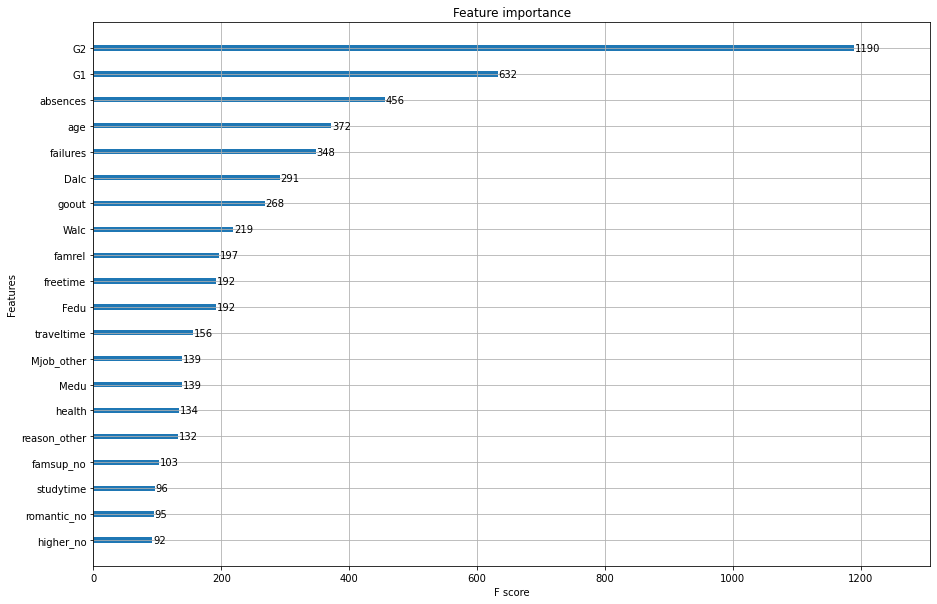

In [104]:
# importent features, top 20

xgb.plot_importance(xgb_model, max_num_features = 20)
plt.show()

In [105]:
importance_feat = pd.DataFrame(list(xgb_model.get_fscore().items()),
                               columns = ['Feature','Importance']).sort_values('Importance', ascending=False).reset_index(drop=True)

importance_feat.head(20)

,Feature,Importance
0,G2,1190
1,G1,632
2,absences,456
3,age,372
4,failures,348
5,Dalc,291
6,goout,268
7,Walc,219
8,famrel,197
9,Fedu,192


In [106]:
print(xgb_model.predict(dtest)[0:10])

[11.150905  6.303889 12.325481  8.668925  9.569426 12.988332 10.464145
  8.974667 12.762217 16.463493]


In [107]:
key_features = list(importance_feat['Feature'].values[0:40])
key_features

['G2',
 'G1',
 'absences',
 'age',
 'failures',
 'Dalc',
 'goout',
 'Walc',
 'famrel',
 'Fedu',
 'freetime',
 'traveltime',
 'Medu',
 'Mjob_other',
 'health',
 'reason_other',
 'famsup_no',
 'studytime',
 'romantic_no',
 'higher_no',
 'sex_F',
 'schoolsup_no',
 'famsize_GT3',
 'Fjob_services',
 'address_R',
 'guardian_father',
 'reason_course',
 'Fjob_at_home',
 'Fjob_other',
 'Mjob_services',
 'activities_no',
 'internet_no',
 'nursery_no',
 'school_GP',
 'higher_yes',
 'reason_home',
 'famsize_LE3',
 'Mjob_teacher',
 'sex_M',
 'romantic_yes']

In [121]:
# Student report card (poorly performing)

students_in_trouble = x_test[x_test['G3'] < 10]

for index,row in students_in_trouble.iterrows():
    print(f"Student ID : {index}")
    for feat in key_features:
        if row[feat] < data[feat].quantile(0.25):
            print(f"\t Below - {feat}: {row[feat]} class_avg : {np.round(np.mean(data[feat]),2)}")
            
        if row[feat] > data[feat].quantile(0.75):
            print(f"\t Above - {feat}: {row[feat]} class_avg : {np.round(np.mean(data[feat]),2)}")
            

Student ID : 500
	 Below - G2: 7 class_avg : 11.57
	 Below - G1: 6 class_avg : 11.4
	 Above - absences: 12 class_avg : 3.66
	 Above - failures: 1 class_avg : 0.22
	 Above - Dalc: 5 class_avg : 1.5
	 Above - goout: 5 class_avg : 3.18
	 Above - Walc: 5 class_avg : 2.28
	 Below - Medu: 1 class_avg : 2.51
	 Below - health: 1 class_avg : 3.54
	 Above - higher_no: 1 class_avg : 0.11
	 Above - guardian_father: 1 class_avg : 0.24
	 Below - higher_yes: 0 class_avg : 0.89
Student ID : 582
	 Below - G2: 8 class_avg : 11.57
	 Below - G1: 6 class_avg : 11.4
	 Above - age: 19 class_avg : 16.74
	 Below - famrel: 1 class_avg : 3.93
	 Below - Medu: 1 class_avg : 2.51
	 Above - higher_no: 1 class_avg : 0.11
	 Above - internet_no: 1 class_avg : 0.23
	 Below - higher_yes: 0 class_avg : 0.89
Student ID : 177
	 Below - G2: 8 class_avg : 11.57
	 Below - G1: 9 class_avg : 11.4
	 Above - failures: 1 class_avg : 0.22
	 Above - Walc: 4 class_avg : 2.28
	 Below - Medu: 1 class_avg : 2.51
	 Above - higher_no: 1 cl